In [44]:
import numpy as np
import os
import itertools
from scipy.ndimage import zoom
import cv2 as cv

# Original dimensions: 70, 740, 856

# training data
image_path = 'numpy_data/Ultrasound Volumes/'
segmentation_path = 'numpy_data/Patient Segmentations/'
image_file_list = [image_path + f for f in os.listdir(image_path) if f.endswith('.npy')]
segmentation_file_list = [segmentation_path + f for f in os.listdir(segmentation_path) if f.endswith('.npy')]

# testing data
t_image_path = 'numpy_data/Ultrasound Volumes/Testing Data/'
t_segmentation_path = 'numpy_data/Patient Segmentations/Testing Data/'
t_image_file_list = [t_image_path + f for f in os.listdir(t_image_path) if f.endswith('.npy')]
t_segmentation_file_list = [t_segmentation_path + f for f in os.listdir(t_segmentation_path) if f.endswith('.npy')]


# determine uniform dimensions
def add_elements(dict, key, value1, value2):
    if key not in dict:
        dict[key] = []
    dict[key].append(value1)
    dict[key].append(value2)

dimensions = {}
for file in itertools.chain(segmentation_file_list, t_segmentation_file_list):
    segmentation_array = np.load(file)
    x, y, z = np.where(segmentation_array != 0)
    add_elements(dimensions, 'x', min(x), max(x))
    add_elements(dimensions, 'y', min(y), max(y))
    add_elements(dimensions, 'z', min(z), max(z))

# segmentation_array = segmentation_array[min(x):max(x)+1, min(y):max(y)+1, min(z):max(z)+1]
x_list = dimensions.get('x')
y_list = dimensions.get('y')
z_list = dimensions.get('z')

min_x = min(x_list)
max_x = max(x_list)
min_y = min(y_list)
max_y = max(y_list)
min_z = min(z_list)
max_z = max(z_list)

In [45]:
# crop and stack training arrays

segmentation_arrays = []
for file in segmentation_file_list:
    seg_arr = np.load(file)
    # resize image
    x_axis = 128/(len(seg_arr[0]))
    y_axis = 128/(len(seg_arr[0][0]))
    z_axis = 128/(len(seg_arr))
    resized_arr = zoom(seg_arr, (z_axis, x_axis, y_axis))
    # convert all non-zero values to 1
    # resized_arr = np.where(resized_arr > 0.0, 1, 0)
    segmentation_array = np.expand_dims(resized_arr, 3)
    segmentation_arrays.append(segmentation_array)

    
image_arrays = []
for file in image_file_list:
    img_arr = np.load(file)
    # resize image
    x_axis = 128/(len(img_arr[0]))
    y_axis = 128/(len(img_arr[0][0]))
    z_axis = 128/(len(img_arr))
    resized_arr = zoom(img_arr, (z_axis, x_axis, y_axis))
    image_array = np.expand_dims(resized_arr, 3)
    image_arrays.append(image_array)


stacked_image_array = np.stack(image_arrays)
stacked_segmentation_array = np.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/stacked_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/stacked_segmentation_array'

np.save(image_file, stacked_image_array)
np.save(segmentation_file, stacked_segmentation_array)

C:\Users\z.hu\AppData\Local\Continuum\anaconda3\envs\brachyTest\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(24, 128, 128, 128, 1)
(24, 128, 128, 128, 1)


In [46]:
# crop and stack testing arrays

segmentation_arrays = []
for file in t_segmentation_file_list:
    seg_arr = np.load(file)
    # resize image
    x_axis = 128/(len(seg_arr[0]))
    y_axis = 128/(len(seg_arr[0][0]))
    z_axis = 128/(len(seg_arr))
    resized_arr = zoom(seg_arr, (z_axis, x_axis, y_axis))
    # convert all non-zero values to 1
    # resized_arr = np.where(resized_arr > 0.0, 1, 0)
    segmentation_array = np.expand_dims(resized_arr, 3)
    segmentation_arrays.append(segmentation_array)

    
image_arrays = []
for file in t_image_file_list:
    img_arr = np.load(file)
    # resize image
    x_axis = 128/(len(img_arr[0]))
    y_axis = 128/(len(img_arr[0][0]))
    z_axis = 128/(len(img_arr))
    resized_arr = zoom(img_arr, (z_axis, x_axis, y_axis))
    image_array = np.expand_dims(resized_arr, 3)
    image_arrays.append(image_array)


stacked_image_array = np.stack(image_arrays)
stacked_segmentation_array = np.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/test_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/test_segmentation_array'

np.save(image_file, stacked_image_array)
np.save(segmentation_file, stacked_segmentation_array)

(6, 128, 128, 128, 1)
(6, 128, 128, 128, 1)


In [47]:
%matplotlib notebook

In [48]:
import matplotlib.pyplot as plt

test_array = np.load('numpy_data/Ultrasound Volumes/ultrasound03.npy')
test_array2 = np.load('numpy_data/Patient Segmentations/brachy_patient03.npy')
# plt.imshow(test_array[11])

In [49]:
# Multi-slice view code extracted and adapted from: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

(108, 740, 856)
0.14953271028037382
(16, 128, 128)


<IPython.core.display.Javascript object>


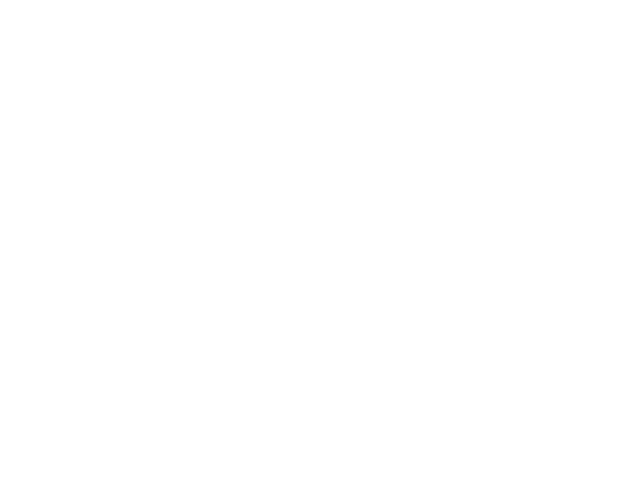

In [50]:
# cropped_arr = test_array[min_x:max_x+1, :, :]
from skimage.transform import resize
import numpy as np
from scipy.ndimage import zoom

print(test_array.shape)
# x = resize(test_array, (128, 128, 128), preserve_range=True)
x_axis = 128/(len(test_array[0]))
y_axis = 128/(len(test_array[0][0]))
z_axis = 16/(len(test_array))
print(y_axis)
x = zoom(test_array, (z_axis, x_axis, y_axis))
print(x.shape)
multi_slice_viewer(x)

(128, 128, 128, 1)


<IPython.core.display.Javascript object>


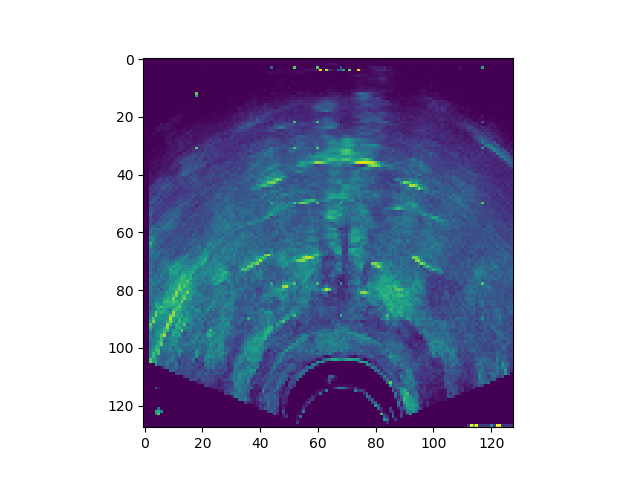

In [55]:
arr = image_arrays[2]
print(arr.shape)
multi_slice_viewer(arr[:, :, :, 0])

In [52]:
%matplotlib notebook

(128, 128, 128)


<IPython.core.display.Javascript object>


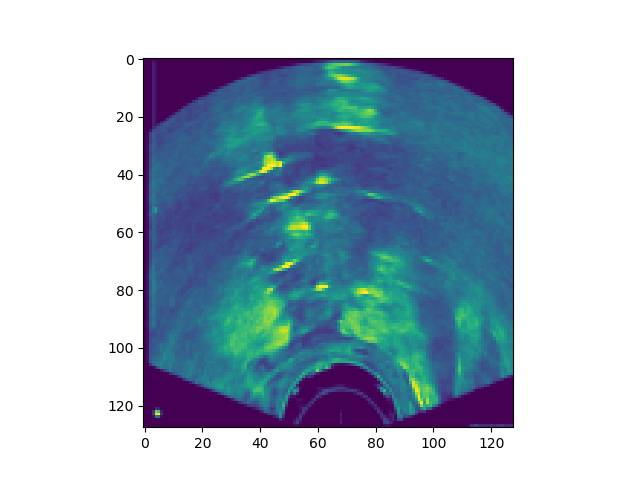

In [53]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = np.load('numpy_data/Ultrasound Volumes/ultrasound03.npy')
image = resize(image, (128, 128, 128), preserve_range=True)
print(image.shape)

alpha = 1.3 # Simple contrast control
beta = 40    # Simple brightness control

new_image = np.zeros(image.shape, image.dtype)

for idx in range(len(image)):
    img_slice = image[idx, :, :]
    new_slice = cv.convertScaleAbs(img_slice, alpha=alpha, beta=beta)
    new_image[idx, :, :] = new_slice

multi_slice_viewer(new_image)